In [27]:
import csv
import numpy as np
import collections
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import functools
from matplotlib import pylab
%matplotlib inline

In [2]:
data = []
counter = 0
with open('train_data.csv', 'r') as f:
    reader = csv.DictReader(f)
    for i,row in enumerate(reader):
        if not row['off'] and not row['def']:
            print(i, row)
            counter += 1
        data.append(row)
print(counter)

0


In [3]:
grouped_by_game = collections.defaultdict(list)
for line in data:
    grouped_by_game[line['gameid']].append(line)
grouped_by_game = list(grouped_by_game.values())

In [4]:
for game in grouped_by_game:
    for play_dict in game:
        for key in play_dict:
            try:
                play_dict[key] = int(play_dict[key])
            except:
                pass

In [5]:
for game in grouped_by_game:
    game.sort(key = lambda x: -int(x['time']))

In [6]:
total_average_yardage = []
moving_average = []
num_plays_before_calc = 3
for game in grouped_by_game:
    num_total_yards = (0, 0)
    num_plays = (0, 0)
    yard_per_play=[]
    first_team_yards=0
    first_team_plays=0
    second_team_yards=0
    second_team_plays=0
    
    for i in range(len(game)-1):
        play_dict = game[i]
        alph_first_team = play_dict['off'] if play_dict['off']<play_dict['def'] else play_dict['def']
        next_play_dict = game[i+1]
        if next_play_dict['down'] is not None and play_dict['down'] is not None and play_dict['ydline'] !='' and next_play_dict['ydline'] !='' and next_play_dict['off']==play_dict['off'] and next_play_dict['description'].find('punt')==-1:
            progress = play_dict['ydline']-next_play_dict['ydline']
            if play_dict['off']==alph_first_team:
                first_team_yards+=progress
                first_team_plays+=1
                if first_team_plays>num_plays_before_calc:
                    moving_average.append(first_team_yards/first_team_plays)
            else:
                second_team_yards+=progress
                second_team_plays+=1
                if second_team_plays>num_plays_before_calc:
                    moving_average.append(second_team_yards/second_team_plays)
            yard_per_play.append(progress)
            
    total_average_yardage.append(first_team_yards/first_team_plays)
    total_average_yardage.append(second_team_yards/second_team_plays)

In [7]:
total_average_yardage = np.array(total_average_yardage).reshape(len(total_average_yardage), 1)
moving_average = np.array(moving_average).reshape(len(moving_average), 1)

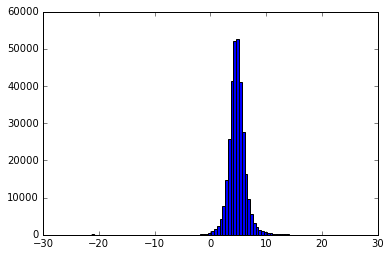

In [8]:
plt.hist(moving_average, 100)
plt.show()

In [9]:
for i,game in enumerate(grouped_by_game):
    first_team_yards=0.0
    first_team_plays=0.0
    second_team_yards=0.0
    second_team_plays=0.0
    for j,play_dict in enumerate(game):
        if j < len(game)-1:
            alph_first_team = play_dict['off'] if play_dict['off']<play_dict['def'] else play_dict['def']
            next_play_dict = game[j+1]
            if next_play_dict['down'] is not None and play_dict['down'] is not None and play_dict['ydline'] !='' and next_play_dict['ydline'] !='' and next_play_dict['off']==play_dict['off'] and next_play_dict['description'].find('punt')==-1:
                progress = play_dict['ydline']-next_play_dict['ydline']
                if play_dict['off']==alph_first_team:
                    first_team_yards+=progress
                    first_team_plays+=1
                    play_dict['avg_yards'] = first_team_yards/first_team_plays
                    play_dict['num_plays_exec'] = first_team_plays
                else:
                    second_team_yards+=progress
                    second_team_plays+=1
                    play_dict['avg_yards'] = second_team_yards/second_team_plays 
                    play_dict['num_plays_exec'] = second_team_plays
            else: #if yards didn't change/it was not a standard play (i.e. field goal)
                if play_dict['off']==alph_first_team and first_team_plays>0:
                    play_dict['avg_yards'] = first_team_yards/first_team_plays
                    play_dict['num_plays_exec'] = first_team_plays
                elif second_team_plays>0:
                    play_dict['avg_yards'] = second_team_yards/second_team_plays
                    play_dict['num_plays_exec'] = second_team_plays

In [10]:
    twenty_perecentile = np.percentile(moving_average, 20)
    forty_percentile = np.percentile(moving_average, 40)
    sixty_percentile = np.percentile(moving_average, 60)
    eighty_percentile = np.percentile(moving_average, 80)

In [11]:
def put_into_bucket(play_dict):
    yard = play_dict['ydline'] // 10
    down = play_dict['down']
    if play_dict['togo'] <= 2:
        togo = 0
    elif play_dict['togo'] <= 4:
        togo = 1
    elif play_dict['togo'] <= 6:
        togo = 2
    elif play_dict['togo'] <= 8:
        togo = 3
    elif play_dict['togo'] <= 10:
        togo = 4
    elif play_dict['togo'] <= 15:
        togo = 5
    elif play_dict['togo'] <= 20:
        togo = 6
    else:
        togo = 7
    #average yardage
    if play_dict['avg_yards'] <= twenty_perecentile:
        avg_yards = 1
    elif play_dict['avg_yards'] <= forty_percentile:
        avg_yards = 2
    elif play_dict['avg_yards'] <= sixty_percentile:
        avg_yards = 3
    elif play_dict['avg_yards'] <= eighty_percentile:
        avg_yards = 4
    else:
        avg_yards = 5
    
    if play_dict['off'] < play_dict['def']:
        posession = 1
    else:
        posession = 0
    return (yard, down, togo, avg_yards, posession)

In [12]:
def group_by_score_change(game, original_scores = None):
    if not game:
        return []
    if original_scores is None:
        original_scores = collections.defaultdict(int)
    changed_team = None
    changed_score = None
    for i, play in enumerate(game):
        if original_scores[play['off']] != play['offscore']:
            changed_team = play['off']
            changed_score = play['offscore'] - original_scores[changed_team]
            break
        if original_scores[play['def']] != play['defscore']:
            changed_team = play['def']
            changed_score = play['defscore'] - original_scores[changed_team]
            break     
    
    if changed_team is None:
        return [('', 0,game)]
    
    new_scores = collections.defaultdict(int)
    new_scores[play['off']] = play['offscore']
    new_scores[play['def']] = play['defscore']
    return [(changed_team, changed_score, game[:i+1])] + group_by_score_change(game[i+1:], new_scores)    

In [13]:
def bucketable(play):
    if not play['down']:
        return False
    if play['down'] < 1:
        return False
    if play['down'] > 4:
        return False
    if not play['togo']:
        return False
    if play['togo'] < 1:
        return False
    if not play['ydline']:
        return False
    if play['ydline'] < 1:
        return False
    if not play['off'] or not play['def']:
        return False
    if 'num_plays_exec' not in play or play['num_plays_exec'] <= 3:
        return False
    return True
    


In [23]:
def possession(play):
    if play_dict['off'] < play_dict['def']:
        return 1
    else:
        return 0

def bucket_group(group):
    global test
    test = group
    team, diff, group = group
    answer = []
    teams = set()

    for play in group:
        teams.add(play['off'])
        teams.add(play['def'])
    if '' in teams:
        teams.remove('')
    if team:
        #print(teams)
        pos = 1 - sorted(teams).index(team)
    
    if diff != 0:
        group2 = group[:-1]
    else:
        group2 = group
    for i, play in enumerate(group2):
        if play['time'] in (1800, 3600):
            if i == 0 or group2[i-1]['time'] in (1800, 3600):
                answer.append([6])
        if bucketable(play):
            answer.append(put_into_bucket(play))
        else:
            answer.append([6])
            
    
        
    if team:
        play_dict = group[-1]
        if 'avg_yards' in play_dict:
            if play_dict['avg_yards'] <= twenty_perecentile:
                avg_yards = 1
            elif play_dict['avg_yards'] <= forty_percentile:
                avg_yards = 2
            elif play_dict['avg_yards'] <= sixty_percentile:
                avg_yards = 3
            elif play_dict['avg_yards'] <= eighty_percentile:
                avg_yards = 4
            else:
                avg_yards = 5
            if answer and answer[-1] == [6]:
                answer = answer[:-1]
            if diff == 2:
                answer.append([1, avg_yards, pos])
                answer.append([5, avg_yards, 1-pos])
            elif diff == 3:
                answer.append([0, avg_yards, pos])
                answer.append([5, avg_yards, pos])
            elif diff == 6:
                answer.append([2, avg_yards, pos])
                answer.append([5, avg_yards, pos])
            elif diff == 7:
                answer.append([2, avg_yards, pos])
                answer.append([3, avg_yards, pos])
                answer.append([5, avg_yards, pos])
            elif diff == 8:
                answer.append([2, avg_yards, pos])
                answer.append([4, avg_yards, pos])
                answer.append([5, avg_yards, pos])
            elif diff != 0:
                answer.append([6])
    return answer
        

In [15]:
def bucket_game(game):
    grouped = group_by_score_change(game)
    answer = []
    for group in grouped:
        answer += bucket_group(group)
    return answer
        


In [16]:
counter = 0
for game in grouped_by_game:
    for play in game:
        if 'num_plays_exec' not in play:
            counter+=1
counter

2696

In [24]:
bucket_sequence = []
for game in grouped_by_game:
    bucket_sequence += bucket_game(game)
    bucket_sequence += [6]

In [25]:
bucket_sequence[:50]

[[6],
 [6],
 [6],
 [6],
 [6],
 [2, 1, 1],
 [3, 1, 1],
 [5, 1, 1],
 [6],
 (7, 2, 0, 5, 0),
 (6, 1, 4, 4, 0),
 (6, 2, 2, 4, 0),
 (6, 3, 0, 5, 0),
 (3, 1, 4, 5, 0),
 (3, 2, 4, 5, 0),
 (1, 1, 4, 5, 0),
 (1, 2, 4, 5, 0),
 (1, 3, 4, 5, 0),
 [2, 5, 0],
 [3, 5, 0],
 [5, 5, 0],
 (1, 1, 4, 4, 0),
 (1, 2, 4, 4, 0),
 (1, 2, 4, 3, 0),
 (0, 3, 2, 3, 0),
 (0, 4, 2, 3, 0),
 [0, 3, 0],
 [5, 3, 0],
 (6, 1, 4, 1, 1),
 (6, 2, 4, 1, 1),
 (6, 3, 3, 1, 1),
 (6, 4, 3, 1, 1),
 (8, 1, 4, 3, 0),
 (7, 2, 1, 4, 0),
 (5, 1, 4, 4, 0),
 (4, 2, 0, 5, 0),
 (3, 1, 4, 5, 0),
 (2, 2, 1, 5, 0),
 (1, 1, 4, 5, 0),
 (1, 2, 2, 4, 0),
 (1, 3, 3, 5, 0),
 (0, 1, 0, 4, 0),
 [2, 4, 0],
 [3, 4, 0],
 [5, 4, 0],
 (5, 1, 4, 1, 1),
 (5, 2, 3, 1, 1),
 (5, 3, 3, 1, 1),
 (5, 4, 3, 1, 1),
 (8, 1, 4, 4, 0)]

In [ ]:
grouped_by_game[0][19:22]

In [26]:
import pickle
with open('basic_buckets_with_avg_yards.pkl', 'wb') as f:
    pickle.dump(bucket_sequence, f, -1)

In [ ]:
sum(len(game) for game in grouped_by_game)

In [ ]:
#dump cell

counter = 0
features = ['down', 'togo']
for game in grouped_by_game:
    for i, play in enumerate(game):
        missing = False
        for feature in features:
            if not play[feature]:
                missing = True
        if missing:
            counter += 1
            scores = collections.defaultdict(set)
            num_gaps = 1
            for j in range(i-1, i + 1):
                if 0 <= j < len(game):
                    scores[game[j]['off']].add(game[j]['offscore'])
                    scores[game[j]['def']].add(game[j]['defscore'])
                    for feature in features:
                        if not game[j][feature]:
                            num_gaps += 1
            score_changed = False
            for team in scores:
                if len(scores) >= 1:
                    score_changed = True
                #if max(scores[team]) - min(scores[team]) in (2,3):
                #    num_gaps -= 1
                #if max(scores[team]) - min(scores[team]) in (6,7,8):
                #    num_gaps -= 2
            #if num_gaps > 0:
            #    #print(play)
            #    pass
            if not score_changed:
                print(play)
                        
for j, game in enumerate(grouped_by_game):
    scores = collections.defaultdict(list)
    for play in game:
        scores[play['off']].append(play['offscore'])
        scores[play['def']].append(play['defscore'])

    for i in range(2, len(game)):
        for team in scores:
            try:
                if len(set((scores[team][i], scores[team][i-1], scores[team][i-2]))) == 3:
                    print(j, i,scores[team][i], scores[team][i-1], scores[team][i-2])
            except:
                pass